In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


# Part 1: Data Preprocessing
● Load the arXiv summarization dataset.
● Select a subset of 5,000 samples.
● Extract input and target pairs:
○ Input: Article.
○ Target: Abstract/Summary
● Tokenize the dataset using the tokenizer from your base model.
● Split the data into Training (80%), Validation (10%), and Test (10%) sets.

In [4]:
dataset = load_dataset("ccdv/arxiv-summarization")
subset = dataset['train'].select(range(5000))

In [5]:
def preprocess(example):
    return {
        "input": example["article"],
        "target": example["abstract"]
    }
subset = subset.map(preprocess, remove_columns=subset.column_names)


In [6]:
local_model_path = "./Llama-3.2-3B-Instruct"  
tokenizer = AutoTokenizer.from_pretrained(local_model_path, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [7]:
def tokenize_function(example):
    model_inputs = tokenizer(
        example["input"], max_length=512, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        example["target"], max_length=512, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = subset.map(tokenize_function, batched=True, remove_columns=["input", "target"])

In [8]:
indices = list(range(len(tokenized_dataset)))
train_val_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.1111, random_state=42)  # 0.1111*0.9 ≈ 0.1

train = tokenized_dataset.select(train_indices)
val = tokenized_dataset.select(val_indices)
test = tokenized_dataset.select(test_indices)

dataset_dict = DatasetDict({
    "train": train,
    "validation": val,
    "test": test
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
})


# Part 2: LoRA-Based Fine-Tuning

In [8]:
pip install bitsandbytes

Note: you may need to restart the kernel to use updated packages.


In [9]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    torch_dtype=torch.float16  # or "auto"
)


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.21s/it]


In [11]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# 4. Training arguments
training_args = TrainingArguments(
    output_dir="./lora-llama3-3b-arxiv",
    per_device_train_batch_size=2,  # Try 2, increase if you have spare VRAM
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=True,
    learning_rate=2e-4,
    report_to="none"
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=data_collator,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [14]:
trainer.train()

# 7. Save the fine-tuned model and tokenizer
model.save_pretrained("./lora-llama3-3b-arxiv/final")
tokenizer.save_pretrained("./lora-llama3-3b-arxiv/final")

Epoch,Training Loss,Validation Loss
1,2.238100,2.243297
2,2.208800,2.224691
3,2.156300,2.218255
4,2.154300,2.216240


('./lora-llama3-3b-arxiv/final\\tokenizer_config.json',
 './lora-llama3-3b-arxiv/final\\special_tokens_map.json',
 './lora-llama3-3b-arxiv/final\\tokenizer.json')

In [10]:
import torch
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [11]:
finetuned_model_path = "./lora-llama3-3b-arxiv/final"
base_model_path = "./Llama-3.2-3B-Instruct"


In [12]:
# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

In [13]:
# Load fine-tuned model and tokenizer in 4-bit on GPU
finetuned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path, use_fast=True)
if finetuned_tokenizer.pad_token is None:
    finetuned_tokenizer.pad_token = finetuned_tokenizer.eos_token
finetuned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_path,
    quantization_config=bnb_config,
    device_map="auto"
)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.25s/it]


In [14]:
base_tokenizer = AutoTokenizer.from_pretrained(base_model_path, use_fast=True)
if base_tokenizer.pad_token is None:
    base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    quantization_config=bnb_config,
    device_map="auto"
)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


In [15]:
test_samples = dataset_dict["test"].select(range(10))
inputs = subset.select(test_indices)[:10]["input"]
ground_truths = subset.select(test_indices)[:10]["target"]

def generate_summaries(inputs, model, tokenizer):
    summaries = []
    for text in inputs:
        inputs_enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
        input_ids = inputs_enc.input_ids.to(device)
        attention_mask = inputs_enc.attention_mask.to(device)
        with torch.no_grad():
            output_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=128,  # or 256 if you want longer summaries
                num_beams=4,
                do_sample=False
            )
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

In [16]:
finetuned_summaries = generate_summaries(inputs, finetuned_model, finetuned_tokenizer)
base_summaries = generate_summaries(inputs, base_model, base_tokenizer)

C:\Users\Farjad\anaconda3\envs\jupyter-gpu\lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\Farjad\anaconda3\envs\jupyter-gpu\lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end g

In [17]:
df = pd.DataFrame({
    "input": inputs,
    "ground_truth": ground_truths,
    "finetuned_summary": finetuned_summaries,
    "base_summary": base_summaries
})
df.to_csv("summaries_comparison.csv", index=False)
print("Saved summaries_comparison.csv")

Saved summaries_comparison.csv


# Part 4: Model Evaluation

In [28]:
import pandas as pd
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("summaries_comparison.csv")
print(df)

                                               input  \
0  the family of iron oxyarsenide @xmath5feaso@xm...   
1  we present here l and m band results on v4332 ...   
2  understanding the processes involved in the su...   
3  non - relativistic quantum fluids ( fermions o...   
4  the recent measurements of the vector charmoni...   
5  at a continuous transition , the expression @x...   
6  experimental studies of neutrino oscillations ...   
7  in this paper , we present a formal analysis o...   
8  a major goal of neutron star ( ns ) research h...   
9  studies of lateral interactions between adsorb...   

                                        ground_truth  \
0  the iron arsenide rbfe@xmath0as@xmath0 with th...   
1  l and m band observations of the nova - like v...   
2  we investigate the structure of hybrid stars b...   
3  we report the thermodynamic properties of bose...   
4  we show that the newly measured branching rati...   
5  a simple systematic rule , inspired by high 

In [31]:
# ROUGE
rouge = evaluate.load("rouge")
rouge_finetuned = rouge.compute(predictions=df["finetuned_summary"], references=df["ground_truth"])
rouge_base = rouge.compute(predictions=df["base_summary"], references=df["ground_truth"])

In [32]:
# BLEU
smooth = SmoothingFunction().method1
bleu_finetuned = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth) for ref, pred in zip(df["ground_truth"], df["finetuned_summary"])]
bleu_base = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth) for ref, pred in zip(df["ground_truth"], df["base_summary"])]

In [33]:
# BERTScore
P_finetuned, R_finetuned, F1_finetuned = bert_score(df["finetuned_summary"].tolist(), df["ground_truth"].tolist(), lang="en")
P_base, R_base, F1_base = bert_score(df["base_summary"].tolist(), df["ground_truth"].tolist(), lang="en")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Aggregate results
results = {
    "ROUGE-1": [rouge_finetuned["rouge1"], rouge_base["rouge1"]],
    "ROUGE-L": [rouge_finetuned["rougeL"], rouge_base["rougeL"]],
    "BLEU": [sum(bleu_finetuned)/len(bleu_finetuned), sum(bleu_base)/len(bleu_base)],
    "BERTScore": [F1_finetuned.mean().item(), F1_base.mean().item()]
}
labels = ["Fine-tuned", "Base"]

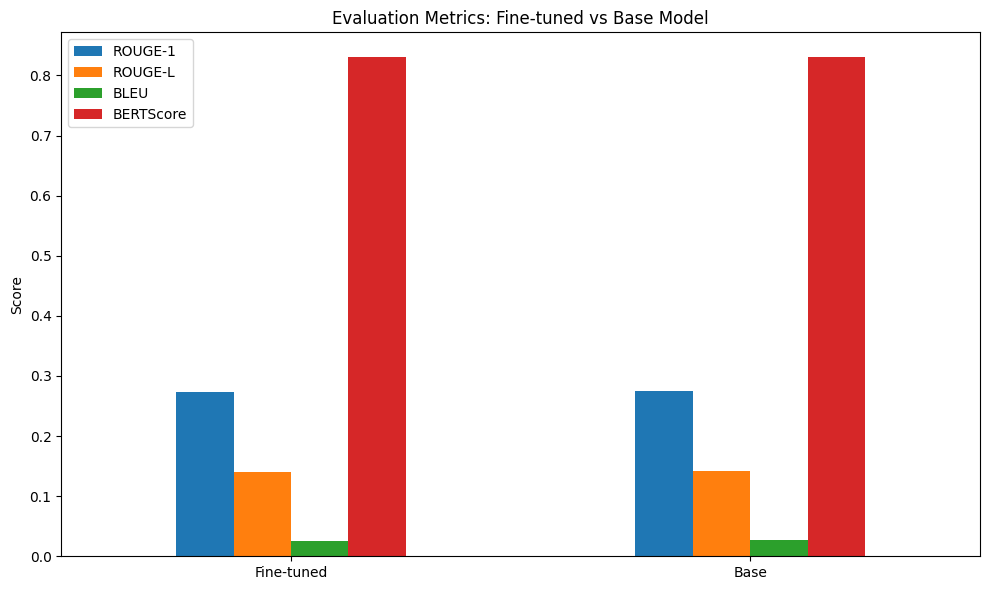

In [35]:
df_results = pd.DataFrame(results, index=labels)
df_results.plot(kind="bar", figsize=(10,6))
plt.title("Evaluation Metrics: Fine-tuned vs Base Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("evaluation_bar_chart.png")
plt.show()

In [36]:
print(df_results)

             ROUGE-1   ROUGE-L      BLEU  BERTScore
Fine-tuned  0.273244  0.140273  0.025094   0.830307
Base        0.274378  0.141729  0.026383   0.830307


# Part 4B: LLM-as-a-Judge Evaluation (Together.ai API)

In [1]:
import openai
import pandas as pd
import random
import time

In [2]:
client = openai.OpenAI(
    api_key="381c3a2dddc050a80df691423e856e9a2334fda9cc28c2a790d04144bf02ddee",  
    base_url="https://api.together.xyz/v1"
)

In [3]:
judge_model = "deepseek-ai/DeepSeek-V3"

In [4]:
df = pd.read_csv("summaries_comparison.csv")

# Randomly select 10 samples
samples = df.sample(10, random_state=42)

In [5]:
def build_prompt(input_text, summary, max_chars=4000):
    # Truncate input to avoid context window errors
    input_text = input_text[:max_chars]
    return f"""
Given the following input and the summary produced, evaluate the summary on:
1. Fluency (Is the summary readable and grammatically correct?)
2. Factuality (Are the statements in the summary correct, and do they reflect the source?)
3. Coverage (Does the summary include the main problem, method, and key findings?)

Use a score from 1 (poor) to 5 (excellent) for each. Provide a short justification for each score.

Input: {input_text}
Generated Summary: {summary}

Respond in this format:
Fluency: [score] - [justification]
Factuality: [score] - [justification]
Coverage: [score] - [justification]
"""

In [6]:
results = []
for idx, row in samples.iterrows():
    prompt = build_prompt(row["input"], row["finetuned_summary"])
    print(f"Evaluating sample {idx+1}/10...")
    try:
        response = client.chat.completions.create(
            model=judge_model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=256,
            temperature=0.0,
        )
        judgement = response.choices[0].message.content
        print(judgement)
        results.append({
            "input": row["input"],
            "summary": row["finetuned_summary"],
            "llm_judgement": judgement
        })
        time.sleep(1.1)  # Increase sleep to avoid rate limits
    except Exception as e:
        print("Error:", e)
        results.append({
            "input": row["input"],
            "summary": row["finetuned_summary"],
            "llm_judgement": str(e)
        })

pd.DataFrame(results).to_csv("llm_judge_results_deepseek.csv", index=False)
print("Saved results to llm_judge_results_deepseek.csv")

Evaluating sample 9/10...
Fluency: 3 - The summary is mostly readable and grammatically correct, but it includes repetitive and nonsensical lines (e.g., the repeated "@xmathX kev feature was detected by _ xmm - newton_@xcite"), which disrupt the flow and clarity.  

Factuality: 4 - The summary accurately reflects the source material for the most part, but the repetitive and incorrect additions (e.g., the "@xmathX kev feature" lines) introduce factual inaccuracies not present in the original text.  

Coverage: 2 - The summary captures some key points (e.g., the challenge of determining neutron star properties, the role of atmospheres, and the case of 1e1207.4-5209), but it misses critical details (e.g., the debate over non-hydrogen atmospheres, the significance of the spectral features, and the proposed interpretations). The repetitive and irrelevant lines further detract from coverage.
Evaluating sample 2/10...
Fluency: 5 - The summary is highly readable and grammatically correct, with

# Part 5: App

In [16]:
import gradio as gr
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import PyPDF2
import openai
import matplotlib.pyplot as plt
import numpy as np
import re

In [17]:
# --- Model Setup ---
finetuned_model_path = "./lora-llama3-3b-arxiv/final"
base_model_path = "./Llama-3.2-3B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
# --- Summarization Function ---
def summarize(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            num_beams=4,
            do_sample=False
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [20]:
# --- LLM-as-a-Judge Function ---
def llm_judge(input_text, summary, api_key, judge_model="deepseek-ai/DeepSeek-V3"):
    client = openai.OpenAI(
        api_key=api_key,
        base_url="https://api.together.xyz/v1"
    )
    prompt = f"""
Given the following input and the summary produced, evaluate the summary on:
1. Fluency (Is the summary readable and grammatically correct?)
2. Factuality (Are the statements in the summary correct, and do they reflect the source?)
3. Coverage (Does the summary include the main problem, method, and key findings?)

Use a score from 1 (poor) to 5 (excellent) for each. Provide a short justification for each score.

Input: {input_text[:4000]}
Generated Summary: {summary}

Respond in this format:
Fluency: [score] - [justification]
Factuality: [score] - [justification]
Coverage: [score] - [justification]
"""
    try:
        response = client.chat.completions.create(
            model=judge_model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=256,
            temperature=0.0,
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {e}"

In [21]:
# --- PDF/Text Extractor ---
def extract_text(file):
    if file.name.endswith(".pdf"):
        pdf = PyPDF2.PdfReader(file)
        text = "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())
    else:
        text = file.read().decode("utf-8")
    return text

# --- File Processing ---
def process_file(file, api_key):
    text = extract_text(file)
    finetuned_summary = summarize(text, finetuned_model, finetuned_tokenizer)
    base_summary = summarize(text, base_model, base_tokenizer)
    return text[:1000], finetuned_summary, base_summary, api_key

# --- Metric Plot ---
def generate_metric_plot():
    metrics = ["ROUGE-1", "ROUGE-L", "BLEU", "BERTScore"]
    fine_tuned_scores = [0.273244, 0.140273, 0.025094, 0.830307]
    base_scores = [0.274378, 0.141729, 0.026383, 0.830307]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, fine_tuned_scores, width, label="Fine-Tuned")
    ax.bar(x + width/2, base_scores, width, label="Base")
    ax.set_ylabel("Score")
    ax.set_title("Evaluation Metrics Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.legend()
    fig.tight_layout()
    return fig

In [22]:
# --- LLM-as-a-Judge Plot ---
def parse_judge_scores(judge_text):
    pattern = r"(Fluency|Factuality|Coverage):\s*(\d)"
    scores = dict(re.findall(pattern, judge_text))
    return [int(scores.get(key, 0)) for key in ["Fluency", "Factuality", "Coverage"]]

def plot_judge_scores(finetuned_text, base_text):
    categories = ["Fluency", "Factuality", "Coverage"]
    fine_scores = parse_judge_scores(finetuned_text)
    base_scores = parse_judge_scores(base_text)

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(x - width/2, fine_scores, width, label="Fine-Tuned")
    ax.bar(x + width/2, base_scores, width, label="Base")
    ax.set_ylabel("Score (1–5)")
    ax.set_title("LLM-as-a-Judge Evaluation")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 5)
    ax.legend()
    fig.tight_layout()
    return fig

In [23]:
# --- Gradio Interface ---
with gr.Blocks() as demo:
    gr.Markdown("# Research Paper Summarizer & LLM-as-a-Judge")

    file = gr.File(label="Upload PDF or TXT")
    api_key = gr.Textbox(label="Together.ai API Key", type="password")

    summarize_btn = gr.Button("Summarize")

    input_text = gr.Textbox(label="Original Text (first 1000 chars)", interactive=False)
    finetuned_summary = gr.Textbox(label="Fine-tuned Model Summary", interactive=False)
    base_summary = gr.Textbox(label="Base Model Summary", interactive=False)

    judge_finetuned_btn = gr.Button("Judge Fine-tuned Summary")
    judge_base_btn = gr.Button("Judge Base Summary")
    judge_finetuned_output = gr.Textbox(label="LLM-as-a-Judge (Fine-tuned)", interactive=False)
    judge_base_output = gr.Textbox(label="LLM-as-a-Judge (Base)", interactive=False)

    plot_metrics_btn = gr.Button("Show Evaluation Metrics Plot")
    metric_plot = gr.Plot(label="Evaluation Metric Comparison")

    plot_judge_btn = gr.Button("Show LLM-as-a-Judge Plot")
    judge_plot = gr.Plot(label="LLM-as-a-Judge Score Comparison")

    summarize_btn.click(
        process_file,
        inputs=[file, api_key],
        outputs=[input_text, finetuned_summary, base_summary, api_key]
    )

    judge_finetuned_btn.click(
        llm_judge,
        inputs=[input_text, finetuned_summary, api_key],
        outputs=judge_finetuned_output
    )

    judge_base_btn.click(
        llm_judge,
        inputs=[input_text, base_summary, api_key],
        outputs=judge_base_output
    )

    plot_metrics_btn.click(
        generate_metric_plot,
        inputs=[],
        outputs=metric_plot
    )

    plot_judge_btn.click(
        plot_judge_scores,
        inputs=[judge_finetuned_output, judge_base_output],
        outputs=judge_plot
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
